# Graded Lab: Evaluation and Debugging Lab

Welcome to this assignment!

Carefully read each Markdown (text) cell, which include instructions and hints. Start by reading the background behind your upcoming tasks.

When you are done, submit your solution by saving it, then clicking on the submit button at the top right side of the page.

## In order for your submission to be graded correctly, you **MUST**:
* **Use the provided variable names**, otherwise the autograder will not be able to locate the variable for grading. 

* **Replace any instances of `None` with your own code.** 

* **Only modify the cells that start with the comment `# GRADED CELL`**.  

* **Use the provided cells for your solution.** You can add new cells to experiment, but these will be omitted when grading. 

To submit your solution, save it, then click on the blue submit button at the top of the page.

<div style="background-color: #FAD888; padding: 10px; border-radius: 3px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1); width:95%
">
<strong>Important note</strong>: Code blocks with None will not run properly. If you run them before completing the exercise, you will likely get an error. 

</div>

## Introduction

In this lab, you will build a systematic pipeline to evaluate, analyze, and improve Large Language Models on mathematical reasoning tasks. This assignment will step you through the complete process of identifying model weaknesses and using targeted fine-tuning to address them.

## Objectives

You'll diagnose model failures, generate relevant training data, and measure improvement effectiveness using real mathematical reasoning tasks.

* **Evaluate Model Performance:** Implement a comprehensive evaluation pipeline to test model accuracy on mathematical problems and establish baseline performance metrics.
* **Analyze Error Categories:** Build an error classification system that categorizes model mistakes into specific types (calculation errors, reasoning errors, format errors) using language model analysis.
* **Generate Targeted Training Data:** Use embedding-based similarity search to identify and select relevant training examples that match the specific error patterns found in the evaluation phase.
* **Fine-tune Model with Targeted Data:** Implement supervised fine-tuning using the targeted training examples to address identified weaknesses and improve model performance on mathematical reasoning tasks.

## Table of Contents
- [Setup](#setup)
- [Evaluate the Model](#section_evaluate) - Exercise 1
- [Analyze the Errors](#section_analyze) - Exercise 2
- [Error Clustering](#errorclustering)
- [Training Data Generation](#section_generate) - Exercise 3
- [Model Fine-tuning](#section_tune) - Exercise 4
- [Model Re-evaluation](#modelreevaluation)
- [Model Accuracy Comparison](#modelaccuracycomparison)
- [Final Results Summary](#finalresultssummary)


---------------------------------------------------------------------------------------------------------------------------------------

# Setup <a id="setup"></a>

As usual, start by importing packages and setting up the notebook.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Disable progress bars to avoid Jupyter context errors
os.environ['HF_DATASETS_DISABLE_PROGRESS_BAR'] = '1'
import warnings
import random
from collections import Counter
from typing import List, Dict

from sklearn.metrics.pairwise import cosine_similarity

from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, GenerationConfig, DataCollatorForLanguageModeling
from datasets import load_from_disk, Dataset
from sklearn.decomposition import PCA

# Also disable programmatically
import datasets
datasets.disable_progress_bar()


import sys
_parent_dir = os.path.abspath('..')
if _parent_dir not in sys.path:
    sys.path.append(_parent_dir)
# Import timing functions from utils (relative to notebook)
from utils.utils import extract_numerical_answer, extract_final_answer, get_model, generate_batch_responses, load_error_analysis_model, cluster_errors, cached_analyze_errors, load_error_analysis_cache, create_cache_key, load_evaluation_cache, cached_evaluate_model
from trl import SFTTrainer

# Set up environment
warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda
GPU: AMD Instinct MI300X VF


---------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# Load GSM8K dataset
# Note: You may see XET progress bar errors - these are harmless warnings and can be ignored
import sys
import io


old_stderr = sys.stderr
sys.stderr = io.StringIO()

dataset = load_from_disk('/app/data/gsm8k', 'main')
train = dataset['train']
test = dataset['test']
eval_dataset = test.select(range(300))

example = test[0]
print(f'Question:\n{example["question"]}')
print()
print(f'Answer:\n{example["answer"]}')

Question:
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

Answer:
Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.
She makes 9 * 2 = $<<9*2=18>>18 every day at the farmer’s market.
#### 18


---------------------------------------------------------------------------------------------------------------------------------------

In [3]:
# # Load the math model
model_name = "/app/models/deepseek-math-7b-base"
model, tokenizer = get_model(model_name)

---------------------------------------------------------------------------------------------------------------------------------------

## Evaluate the Model <a id="section_evaluate"></a>

You will test how well your model performs on math problems before you try to improve it.

### Exercise 1: Evaluate Model Performance

This section sets up the evaluation pipeline for testing model performance.

The `evaluate_model` function:
- Extracts questions and answers from the dataset
- Generates model predictions in batches
- Compares predictions to correct answers
- Calculates accuracy
- Stores results for analysis

**CAREFUL! There are two parts where you need to enter your own code in this cell.**

In [4]:
# GRADED CELL: exercise 1

def evaluate_model(model, tokenizer, dataset, model_name: str) -> Dict:
    """Evaluate model on dataset."""
    
    print(f"Evaluating {model_name}...")
    ### START CODE HERE ###
    # Extract questions and correct answers from the dataset into a list
    # The dataset is a list of dictionaries, each containing a 'question' key.
    # Use list comprehension to iterate over each dictionary (example) in the dataset
    # Access each question with example['question'] inside the list comprehension
    questions = [example['question'] for example in dataset]
    
    # Similarly, extract the numerical answer by passing example['answer'] to extract_numerical_answer()inside the list comprehension
    correct_answers = [example['answer'] for example in dataset]
    ### END CODE HERE ###

    # Generate responses using batch processing
    print("🚀 Generating responses...") 
    model_responses = generate_batch_responses(model, tokenizer, questions, batch_size=8)

    # Calculate accuracy
    correct_count = 0
    results = {
        'model_name': model_name,
        'predictions': [],
        'correct_answers': correct_answers,
        'questions': questions,
        'model_responses': model_responses,
        'correct': []
    }
    
    for i, (correct_answer, response) in enumerate(zip(correct_answers, model_responses)):
        
        predicted_answer = extract_final_answer(response)
        
        ### START CODE HERE ###  
        try:
            # Convert the correct and predicted answer to float.
            correct_num = float(correct_answer.replace(',', '').replace('$', ''))
            predicted_num = float(predicted_answer)
            # Check if the difference between correct_answer and predicted_answer < 1e-3
            is_correct = abs(correct_num - predicted_num) < 1e-3
        except:
            is_correct = False 
        ### END CODE HERE ###  

        if is_correct:
            correct_count += 1
            
        results['predictions'].append(predicted_answer)
        results['correct'].append(is_correct)

    # Calculate final accuracy
    results['accuracy'] = correct_count / len(dataset)

    print(f"✅ Accuracy: {results['accuracy']:.3f} ({correct_count}/{len(dataset)})")
    
    return results

Mathematical reasoning is challenging for LLMs. Expect baseline accuracies around 30-70% depending on problem complexity.

This baseline establishes your starting point. All improvements will be measured against these results.

Run the next cell to evaluate the original model and establish your baseline.

It should take no more than 7 minutes to run this cell.

In [6]:
# Create cache key from questions in the dataset
questions = [example['question'] for example in eval_dataset]
cache_key = create_cache_key("Original Model", questions)

# Try to load from cache first - if exists, use it directly without calling evaluation function
results = load_evaluation_cache(cache_key)

if results is None:
    # Only call the expensive evaluation function if no cache exists
    results = cached_evaluate_model(evaluate_model, model, tokenizer, eval_dataset, "Original Model")
# Save results (same as before)
os.makedirs('lab_results', exist_ok=True)
with open('lab_results/evaluation_results.json', 'w') as f:
    json.dump({
        'accuracy': results['accuracy'],
        'total_examples': len(results['correct']),
        'correct_predictions': sum(results['correct'])
    }, f, indent=2)

# Show some examples of incorrect predictions
incorrect_indices = [i for i, correct in enumerate(results['correct']) if not correct]
print(f"\nFound {len(incorrect_indices)} incorrect predictions")

print("\nExample incorrect predictions:")
for i, idx in enumerate(incorrect_indices[:3]):
    print(f"\n--- Example {i+1} ---")
    print(f"Question: {results['questions'][idx][:100]}...")
    print(f"Correct: {results['correct_answers'][idx]}")
    print(f"Predicted: {results['predictions'][idx]}")

print(f"\n📊 Original Model Accuracy: {results['accuracy']:.3f}")

📂 Loaded evaluation results from cache: /app/data/cache/eval_6090a6eaa9fc1cef.pkl

Found 261 incorrect predictions

Example incorrect predictions:

--- Example 1 ---
Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for ...
Correct: 18
Predicted: 9

--- Example 2 ---
Question: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it ...
Correct: 3
Predicted: 5

--- Example 3 ---
Question: Josh decides to try flipping a house.  He buys a house for $80,000 and then puts in $50,000 in repai...
Correct: 70000
Predicted: 120

📊 Original Model Accuracy: 0.130


## Analyze the Errors <a id="section_analyze"></a>

You will look at what types of errors the model is making so you can fix them.

Error analysis is crucial for targeted improvements. The first cell will load a helper model, and the second will define your error categorization function.

### Exercise 2: Analyze Error Categories

Complete the `analyze_error` function with your implementation.


To generate a good prompt for error analysis using a language model, make sure your prompt does the following:

- **Includes the key parts of the math problem**:
  - The **QUESTION** 
  - The **CORRECT** answer.
  - The **PREDICTED** answer (i.e. the model’s or student's answer).
  
- **Asks the model to categorize the error**, using **exactly one** of the options provided in `ERROR_CATEGORIES`.

- **Tells the model to respond with only the category name**, with no explanations, extra text, or formatting.

- **Keeps the formatting clean and clear**, so it's easy for the language model to follow.

> Example of what you're aiming for (don’t copy this — write your own version):
> - A short paragraph or bullet list describing the error analysis task.
> - Clearly labeled fields: "PROBLEM", "CORRECT ANSWER", "PREDICTED ANSWER".
> - A final line instructing the model to choose **only one category** from the list and respond with **just the category name**.

In [7]:
# Load error analysis model from utils
ERROR_CATEGORIES = [
    "calculation_error",   # Math computation mistakes  
    "reasoning_error",     # Logical reasoning issues
    "incomplete_solution", # Partial or unfinished answers
    "format_error",       # Wrong answer format
    "other"              # Other errors
]

# Initialize local model for error analysis
tokenizer, model, hf_model_available = load_error_analysis_model()

Loading local model for error analysis...
📦 Loading model from: /app/models/llama-3.2-8b
Loading tokenizer...
Loading model weights...
✅ Local model loaded successfully!


In [8]:
# GRADED CELL: exercise 2
def analyze_error(question: str, correct_answer: str, model_response: str, predicted_answer: str) -> Dict:
    """Analyze what type of error the model made using local Hugging Face model."""
    
    # Try using local Hugging Face model if available (same prompt as GPT-4)
    if hf_model_available:
        try:
            ### START CODE HERE ###
            #💡 HINT: Create prompt for error analysis and categorizing the error. makes sure to include the question, correct answer, and predicted answer and ask for one of the ERROR_CATEGORIES and make sure that LLM only responds with category name
            prompt = f"""Analyze this math error and categorize it:
            PROBLEM: {question}
            CORRECT: {correct_answer}
            PREDICTED: {predicted_answer}
            Choose ONE category: {', '.join(ERROR_CATEGORIES)}
            Respond with just the category name."""
            ### END CODE HERE ###
            # Tokenize the prompt 
            inputs = tokenizer.encode(prompt, return_tensors="pt", max_length=512, truncation=True)
            if torch.cuda.is_available():
                inputs = inputs.to(model.device)
            
            # Generate response
            with torch.no_grad():
                outputs = model.generate(
                    inputs, 
                    max_new_tokens=20,  
                    pad_token_id=tokenizer.eos_token_id,
                    num_return_sequences=1,
                    eos_token_id=tokenizer.eos_token_id
                )
            
            # Decode the response
            generated_text = tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)
            category = generated_text.strip().lower()
            
            # Clean up the response and validate
            if category in ERROR_CATEGORIES:
                return {"category": category, "description": f"HF model classified as {category}"}
            
            # If exact match not found, try partial matching
            for cat in ERROR_CATEGORIES:
                if cat.replace("_", " ") in category or any(word in category for word in cat.split("_")):
                    return {"category": cat, "description": f"HF model classified as {cat}"}
                    
        except Exception as e:
            print(f"HF model inference failed: {e}")
            pass
    
    # Fallback to simple rules (same as before)
    if len(model_response) < 50:
        return {"category": "incomplete_solution", "description": "Response too short"}
    elif predicted_answer == "":
        return {"category": "format_error", "description": "No answer extracted"}
    else:
        # Check if it's close (likely calculation error)
        try:
            pred_num = float(predicted_answer)
            correct_num = float(correct_answer)
            if abs(pred_num - correct_num) / max(abs(correct_num), 1) < 0.001:
                return {"category": "calculation_error", "description": "Close but incorrect"}
        except:
            pass
        
        return {"category": "reasoning_error", "description": "Logic error"}
# END GRADED SECTION

##  Error Clustering <a id="errorclustering"></a>

This section analyzes the incorrect predictions made by your model to identify common error patterns.

New training data will be generated to help the model fix its most common mistakes. This targeted approach helps the model learn from its weaknesses and improves performance on challenging mathematical reasoning tasks.

First, review the selected training examples. Then, proceed to fine-tune the model using this focused dataset

In [9]:
# Import caching utilities for error analysis
from utils.utils import cached_analyze_errors, load_error_analysis_cache
import hashlib
from collections import Counter

# Get incorrect predictions
incorrect_indices = [i for i, correct in enumerate(results['correct']) if not correct]

# Prepare error data for analysis
analysis_limit = min(300, len(incorrect_indices))
print(f"Analyzing {analysis_limit} incorrect predictions...")

error_questions = [results['questions'][idx] for idx in incorrect_indices[:analysis_limit]]
error_correct_answers = [results['correct_answers'][idx] for idx in incorrect_indices[:analysis_limit]]
error_model_responses = [results['model_responses'][idx] for idx in incorrect_indices[:analysis_limit]]
error_predicted_answers = [results['predictions'][idx] for idx in incorrect_indices[:analysis_limit]]

# Create cache key for error analysis
error_data = f"errors:{len(error_questions)}:{':'.join(error_questions[:3])}"  # Sample for key
cache_key = hashlib.md5(error_data.encode()).hexdigest()[:16]

# Try to load from cache first - if exists, use it directly without calling analyze_error functions
error_analyses = load_error_analysis_cache(cache_key)

if error_analyses is not None:
    print("✅ Found cached error analysis - skipping LLM calls completely!")
else:
    print("🔄 No cache found - running fresh error analysis and caching results...")
    # Only call the expensive error analysis function if no cache exists
    error_analyses = cached_analyze_errors(
        analyze_error, 
        error_questions,
        error_correct_answers, 
        error_model_responses, 
        error_predicted_answers
    )

# Add original indices back to the analyses for consistency with later code
for i, analysis in enumerate(error_analyses):
    analysis['example_index'] = incorrect_indices[i] if i < len(incorrect_indices) else i

# Save results
with open('lab_results/error_analysis.json', 'w') as f:
    json.dump(error_analyses, f, indent=2)

# Show error distribution
error_categories = [analysis['category'] for analysis in error_analyses]
category_counts = Counter(error_categories)

print("\n📊 Error Types Found:")
for category, count in category_counts.most_common():
    percentage = (count / len(error_analyses)) * 100
    print(f"  {category}: {count} ({percentage:.1f}%)")

Analyzing 261 incorrect predictions...
📂 Loaded error analysis results from cache: /app/data/cache/error_76b6acad35bda5ef.json
✅ Found cached error analysis - skipping LLM calls completely!

📊 Error Types Found:
  calculation_error: 232 (88.9%)
  reasoning_error: 21 (8.0%)
  incomplete_solution: 4 (1.5%)
  other: 3 (1.1%)
  format_error: 1 (0.4%)


In [10]:
# Cluster the errors and get results
embeddings, cluster_labels, embedding_model, kmeans, n_clusters = cluster_errors(error_analyses, results['questions'])

Loading sentence transformer for clustering...
Loading sentence transformer from local path: /app/models/all-MiniLM-L6-v2
Creating embeddings...
Clustering into 3 groups...


The next cell will group similar errors and show key patterns. This helps you see which errors are most common and how they group together, making it easier to target improvements.


  Example: Janet’s ducks lay 16 eggs per day. She eats three for breakf...
  Example: A robe takes 2 bolts of blue fiber and half that much white ...
  Example: James decides to run 3 sprints 3 times a week.  He runs 60 m...


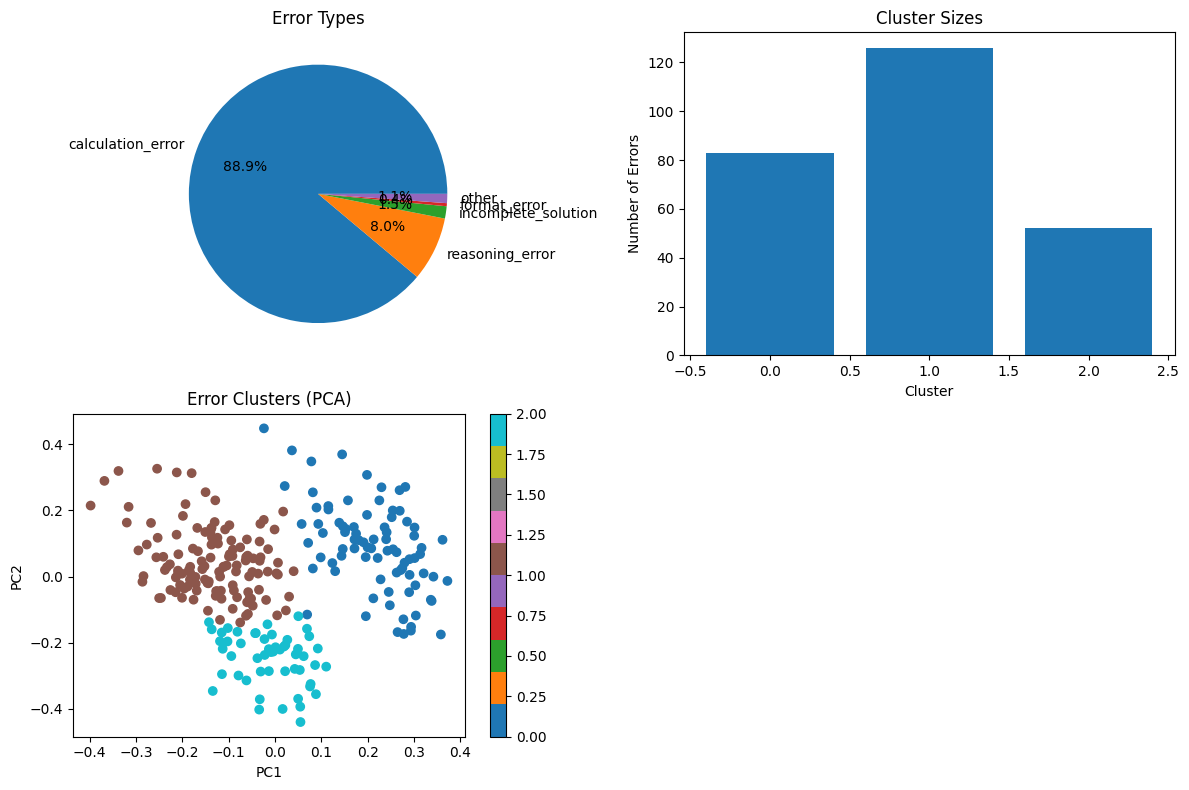

In [11]:
# Add cluster info to analyses
for i, analysis in enumerate(error_analyses):
    analysis['cluster'] = int(cluster_labels[i])

# Analyze clusters
cluster_info = {}
for cluster_id in range(n_clusters):
    cluster_errors = [a for a in error_analyses if a['cluster'] == cluster_id]
    categories = [a['category'] for a in cluster_errors]
    
    cluster_info[cluster_id] = {
        'size': len(cluster_errors),
        'main_category': Counter(categories).most_common(1)[0][0],
        'errors': cluster_errors
    }

    if cluster_errors:
        example_idx = cluster_errors[0]['example_index']
        print(f"  Example: {results['questions'][example_idx][:60]}...")

# Simple visualization
plt.figure(figsize=(12, 8))

# 1. Error category pie chart
plt.subplot(2, 2, 1)
category_counts = Counter([a['category'] for a in error_analyses])
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%')
plt.title('Error Types')

# 2. Cluster sizes
plt.subplot(2, 2, 2)
cluster_sizes = [cluster_info[i]['size'] for i in range(n_clusters)]
plt.bar(range(n_clusters), cluster_sizes)
plt.xlabel('Cluster')
plt.ylabel('Number of Errors')
plt.title('Cluster Sizes')

# 3. PCA visualization
plt.subplot(2, 2, 3)
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Error Clusters (PCA)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Save clustering results
with open('lab_results/clusters.json', 'w') as f:
    json.dump({
        'cluster_info': {str(k): {'size': v['size'], 'main_category': v['main_category']} 
                        for k, v in cluster_info.items()},
        'n_clusters': n_clusters
    }, f, indent=2)

## Training Data Generation <a id="section_generate"></a>
Now you want to create some training examples to help the model fix the most common types of errors.

You will use embedding-based similarity search to select relevant examples from the training set that closely match the error patterns identified in your analysis. This approach ensures that the fine-tuning data is targeted and effective for addressing specific weaknesses.

- Group errors by category (calculation, reasoning, format, etc.)
- Use sentence embeddings to find training questions similar to each error type
- Select a balanced set of examples for each error category
- Format the selected examples for model fine-tuning

This targeted data generation will help the model learn from its mistakes and improve performance on challenging mathematical reasoning tasks.

### Exercise 3: Generate Targeted Training Data

The next code cell will create targeted training examples to address the specific error patterns you identified.

Your task is
- **Embedding Creation**: Generate vectors for training questions
- **Similarity Calculation**: Compare error patterns with training examples
- **Index Selection**: Choose most relevant training examples

**CAREFUL! There are two graded parts in this cell.**

In [12]:
# GRADED CELL: exercise 3

# Helper functions for creating training data from error analysis
def create_training_example(question: str, answer: str) -> Dict:
    """Create a training example with question and full answer from train data."""
    return {
        'question': question,
        'answer': answer
    }

class TrainingExampleSelector:
    """Class to select training examples similar to test error patterns using embeddings."""
    
    def __init__(self, error_analyses, train_data, embedding_model, samples_per_category=20):
        self.error_analyses = error_analyses
        self.train_data = train_data
        self.embedding_model = embedding_model
        self.samples_per_category = samples_per_category
        self.error_by_category = {}
        self.train_questions = None
        self.train_embeddings = None
        
    def _group_errors_by_category(self):
        """Group errors by category for processing."""
        self.error_by_category = {}
        for analysis in self.error_analyses:
            category = analysis['category']
            if category not in self.error_by_category:
                self.error_by_category[category] = []
            self.error_by_category[category].append(analysis)
    
    def _create_training_embeddings(self):
        """Create embeddings for all training questions."""
        print("📊 Creating embeddings for training data...")
    
        ### START CODE HERE ###
        # Create a list of questions from the training data.
        # For each example in self.train_data you can access the question with ['question']
        self.train_questions = [dat['question'] for dat in self.train_data]
        # Use embedding_model.encode() on all training questions. Set the batch size to 32.
        self.train_embeddings = self.embedding_model.encode(self.train_questions, batch_size=32, show_progress_bar=True)
        ### END CODE HERE ###
    
    def _calculate_similarity_and_select_indices(self, error_questions):
        """Calculate similarity between error questions and training questions, return top indices."""
        error_embeddings = self.embedding_model.encode(error_questions)
        ### START CODE HERE ###
        #💡 HINT: Calculate similarity between error questions and training questions by using the cosine_similarity function.
        similarity_matrix = cosine_similarity(error_embeddings, self.train_embeddings)
        ### END CODE HERE ### 

        # Get top similar training examples
        similar_indices = set()
        for i, error_question in enumerate(error_questions):

            # Get top similar training examples for this error
            similarities = similarity_matrix[i]
            # Use np.argsort() to get indices of top similar training examples
            top_indices = np.argsort(similarities)[-self.samples_per_category//len(error_questions):]
            # Convert numpy int64 to regular Python int for HuggingFace dataset compatibility
            similar_indices.update([int(idx) for idx in top_indices])
             
        return similar_indices, similarity_matrix
    
    def find_examples(self):
        """Public method to find training examples similar to test error patterns using embeddings."""
        
        print("🔍 Finding similar training examples using embedding similarity...")
        
        # Step 1: Group errors by category
        self._group_errors_by_category()
        
        # Step 2: Create embeddings for training data
        self._create_training_embeddings()
        
        selected_training_examples = []
        
        # Step 3: Process each error category
        for category, category_errors in self.error_by_category.items():
            print(f"\n🎯 Processing {category} errors ({len(category_errors)} examples):")
            
            # Create embeddings for error questions (from test set - for similarity only, not training)
            error_questions = []
            for error in category_errors:
                idx = error['example_index']
                error_questions.append(results['questions'][idx])
            
            if not error_questions:
                continue

            # Step 4: Calculate similarity and get indices
            similar_indices, similarity_matrix = self._calculate_similarity_and_select_indices(error_questions)
            
            # Step 5: Create training examples from selected indices
            category_examples = []
            for train_idx in similar_indices:
                question = self.train_data[train_idx]['question']
                answer = self.train_data[train_idx]['answer']
                category_examples.append(create_training_example(question, answer))
            
            selected_training_examples.extend(category_examples)
            print(f"   • Selected {len(category_examples)} similar training examples")
            
            # Show example similarity
            if category_examples:
                best_idx = int(np.argmax(similarity_matrix[0]))  # Convert to Python int
                similarity_score = similarity_matrix[0][best_idx]
                print(f"   • Best similarity score: {similarity_score:.3f}")
                print(f"   • Example: {self.train_data[best_idx]['question'][:80]}...")
        
        return selected_training_examples

def find_similar_training_examples(error_analyses, train_data, embedding_model, samples_per_category=20):
    """Find training examples similar to test error patterns using embeddings."""
    selector = TrainingExampleSelector(error_analyses, train_data, embedding_model, samples_per_category)
    return selector.find_examples()

New training data will be generated to help the model fix its most common mistakes. This targeted approach helps the model learn from its weaknesses and improves performance on challenging mathematical reasoning tasks.

First, review the selected training examples. Then, proceed to fine-tune the model using this focused dataset

In [13]:
# Identify error patterns from your analysis
print("Creating training examples from train set based on error patterns...")

# Get the most common error categories from your analysis
if 'error_analyses' in locals() and len(error_analyses) > 0:
    error_categories = [analysis['category'] for analysis in error_analyses]
    category_counts = Counter(error_categories)
    print(f"Main error types found: {list(category_counts.keys())}")
    
    # Use embedding similarity to find relevant training examples
    if 'embedding_model' in locals():
        selector = TrainingExampleSelector(error_analyses, train, embedding_model, samples_per_category=30)
        training_examples = selector.find_examples()
    else:
        print("⚠️ Embedding model not available, falling back to random sampling...")
        train_indices = random.sample(range(len(train)), min(200, len(train)))
        training_examples = []
        for idx in train_indices:
            question = train[idx]['question']
            answer = train[idx]['answer']
            training_examples.append(create_training_example(question, answer))
else:
    # Fallback: random sampling from train set
    print("⚠️ No error analysis available, using random training sampling...")
    train_indices = random.sample(range(len(train)), min(200, len(train)))
    training_examples = []
    for idx in train_indices:
        question = train[idx]['question']
        answer = train[idx]['answer']
        training_examples.append(create_training_example(question, answer))

print(f"\n✅ Created {len(training_examples)} targeted training examples from train set")

# Convert to dataset format  
training_data = {
    'question': [ex['question'] for ex in training_examples],
    'answer': [ex['answer'] for ex in training_examples]
}
training_dataset = Dataset.from_dict(training_data)

# Show a sample
print("\n📝 Sample Training Example:")
sample = training_examples[0]
print(f"Question: {sample['question'][:150]}...")
print(f"Answer: {sample['answer'][:150]}...")

Creating training examples from train set based on error patterns...
Main error types found: ['calculation_error', 'reasoning_error', 'incomplete_solution', 'format_error', 'other']
🔍 Finding similar training examples using embedding similarity...
📊 Creating embeddings for training data...


Batches:   0%|          | 0/234 [00:00<?, ?it/s]


🎯 Processing calculation_error errors (232 examples):
   • Selected 225 similar training examples
   • Best similarity score: 0.788
   • Example: Kelly has 8 chickens that lay 3 eggs each per day. If Kelly sells these eggs for...

🎯 Processing reasoning_error errors (21 examples):
   • Selected 42 similar training examples
   • Best similarity score: 0.688
   • Example: Scott runs 3 miles every Monday through Wednesday. Then he runs twice as far he ...

🎯 Processing incomplete_solution errors (4 examples):
   • Selected 32 similar training examples
   • Best similarity score: 0.643
   • Example: Daryl is loading crates at a warehouse and wants to make sure that they are not ...

🎯 Processing format_error errors (1 examples):
   • Selected 30 similar training examples
   • Best similarity score: 0.667
   • Example: Tom spends $250 to buy gems in a game he plays.  The game gives 100 gems for eac...

🎯 Processing other errors (3 examples):
   • Selected 30 similar training examples
   • 

## Model Fine-tuning <a id="section_tune"></a>

The next cells will format training data for the model, create training and validation sets, set up learning parameters and monitoring, run fine-tuning with progress tracking, and persist the improved model for evaluation

### Exercise 4: Fine-tune Model with Targeted Data

The tokenization function converts your training examples into the format expected by the model.

Your task is to pass the `formatted_texts` to the tokenizer and assign it to the `model_inputs` variable. The tokenizer should also be passed the arguments `truncation=True`, `padding=True`, `max_length=512`, and `return_tensors=None`.

In [14]:
def format_training_examples(examples):
    """Format training examples into conversation format."""
    formatted_texts = []
    for question, answer in zip(examples['question'], examples['answer']):
        # Create a clear conversation format
        formatted_text = f"Question: {question}\nAnswer: {answer}"
        formatted_texts.append(formatted_text)
    return formatted_texts

In [15]:
# GRADED CELL: exercise 4

def tokenize_and_format(examples):
    """Improved tokenization for stable training convergence."""

    # Format training examples using separate formatting function
    formatted_texts = format_training_examples(examples)
    
    ### START CODE HERE ###
    # Use the tokenizer on formatted_texts.
    # Set truncation and padding to True, max_length to 512 and return_tensors to None
    model_inputs = tokenizer(formatted_texts, padding=True, truncation=True, max_length=512, return_tensors=None)
    ### END CODE HERE ###
    # Create labels (copy of input_ids for causal LM)
    model_inputs['labels'] = model_inputs['input_ids'].copy()
    return model_inputs
    

Here, you split the data into training and validation sets.

In [16]:
# Split data and setup training with improved configuration
train_size = int(0.8 * len(training_dataset))
train_data = training_dataset.select(range(train_size))
val_data = training_dataset.select(range(train_size, len(training_dataset)))

print(f"Training on {len(train_data)} examples")
print(f"Validating on {len(val_data)} examples")

print("🔄 Tokenizing training data...")
train_data = train_data.map(
    tokenize_and_format, 
    batched=True, 
    remove_columns=train_data.column_names,
    desc="Tokenizing training data"
)

print("🔄 Tokenizing validation data...")
val_data = val_data.map(
    tokenize_and_format, 
    batched=True, 
    remove_columns=val_data.column_names,
    desc="Tokenizing validation data"
)

Training on 287 examples
Validating on 72 examples
🔄 Tokenizing training data...
🔄 Tokenizing validation data...


## Model Re-evaluation <a id="modelreevaluation"></a>

This section sets up the fine-tuning process with improved stability and monitoring:

- `DataCollatorForLanguageModeling` is used for for efficient batching and padding, optimized for causal language modeling.
- The HuggingFace `Trainer` is used to manage training, evaluation, and model saving.


In [17]:
# Create improved data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Causal language modeling
    pad_to_multiple_of=8,  # For efficiency on modern hardware
    return_tensors="pt"
)

# Improved training arguments for stable convergence
training_args = TrainingArguments(
    # Output and logging
    output_dir='./training_logs',
    logging_strategy='steps',
    logging_steps=5, 
    
    # Evaluation
    eval_strategy='steps', 
    eval_steps=5,  
    
    # Training parameters - more conservative for stability
    learning_rate=1e-8,  
    weight_decay=0.1,   
    warmup_steps=20,    
    max_grad_norm=1.0,   # Gradient clipping for stability
    
    # Batch sizes - smaller for stability
    per_device_train_batch_size=1,   
    per_device_eval_batch_size=2,    
    gradient_accumulation_steps=4,   
    
    # Epochs
    num_train_epochs=2,  
    
    # Disable unnecessary features
    report_to=[],
    save_strategy="no",  # Don't save checkpoints during training
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator,
)

try:
    training_result = trainer.train()
    
    print("\n✅ Fine-tuning complete!")
    print(f"📈 Final training loss: {training_result.training_loss:.4f}")
    
    # Print validation loss progression if available
    log_history = trainer.state.log_history
    eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry and not (entry['eval_loss'] != entry['eval_loss'])]  # Filter out NaN
    # Check for training issues
    train_losses = [entry['loss'] for entry in log_history if 'loss' in entry and not (entry['loss'] != entry['loss'])]  
    
except Exception as e:
    print(f"⚠️ Fine-tuning failed: {e}")
    print("Continuing with original model for demonstration...")

Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
5,1.317200,1.361204,0.723850,7640.000000,0.696844
10,1.342800,1.355880,0.721856,15280.000000,0.697511
15,1.192400,1.340617,0.717963,22920.000000,0.701752
20,1.274800,1.314298,0.709323,30560.000000,0.704281
25,1.240600,1.281765,0.702176,38200.000000,0.708297
30,1.242000,1.251054,0.693902,45840.000000,0.712556
35,1.064700,1.221825,0.681383,53480.000000,0.714312
40,1.075900,1.197450,0.671170,61120.000000,0.717323
45,1.047800,1.172230,0.660509,68760.000000,0.723056
50,1.053100,1.153380,0.644816,76400.000000,0.727851



✅ Fine-tuning complete!
📈 Final training loss: 1.0539


The next code cell will visualize the training and validation loss curves from the fine-tuning process. This helps you monitor convergence detect overfitting, and assess training stability.

Review the plot to ensure your model is improving and training is stable before moving on to evaluation.

📊 Training Loss Analysis:


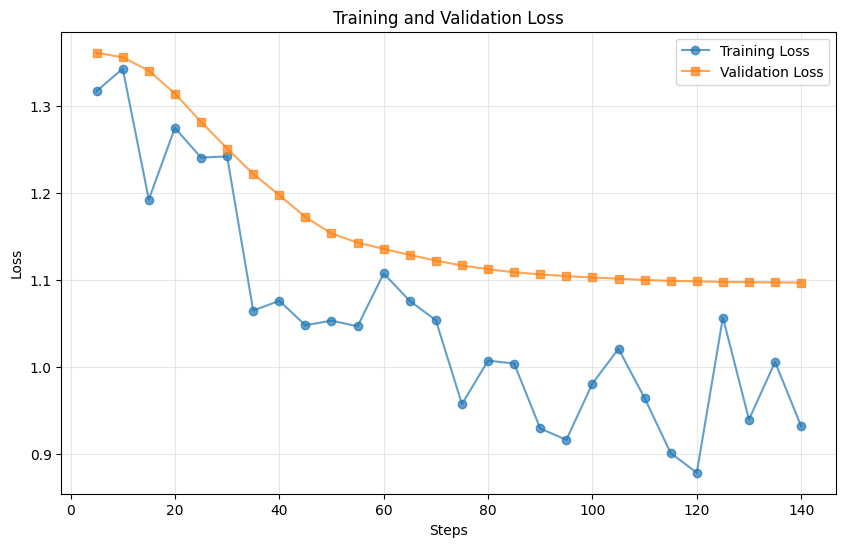

Training losses: [0.8782, 1.0567, 0.9394, 1.0056, 0.9316]
Validation losses: [1.09737229347229, 1.0970500707626343, 1.0969197750091553]
✅ Using fine-tuned model from training!


In [18]:
# Plot training vs validation loss (from solutions.ipynb)
def plot_train_vs_val(log_history):
    """Plot training vs validation loss to check for overfitting."""
    # Separate training and evaluation logs
    train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]

    if len(train_logs) == 0 or len(eval_logs) == 0:
        print("⚠️ Insufficient training/validation data for plotting")
        return

    # Extract values
    train_steps = [log['step'] for log in train_logs]
    train_losses = [log['loss'] for log in train_logs]

    eval_steps = [log['step'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_losses, label='Training Loss', marker='o', alpha=0.7)
    plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='s', alpha=0.7)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print actual values for analysis
    print(f"Training losses: {train_losses[-5:]}")  # Last 5 values
    print(f"Validation losses: {eval_losses[-3:]}")  # Last 3 values

# Visualize training progress if trainer is available
if 'trainer' in locals() and hasattr(trainer, 'state'):
    print("📊 Training Loss Analysis:")
    plot_train_vs_val(trainer.state.log_history)



# Use the fine-tuned model directly from the trainer (already in memory)
if 'trainer' in locals() and hasattr(trainer, 'model'):
    fine_tuned_model = trainer.model
    fine_tuned_tokenizer = tokenizer  # Same tokenizer used for training
    fine_tuned_model.eval()
    print("✅ Using fine-tuned model from training!")
else:
    print("⚠️ No fine-tuned model available")
    print("Using original model for demonstration...")
    fine_tuned_model = model
    fine_tuned_tokenizer = tokenizer

Compare your fine-tuned model to the original model to see how much it improved.

You'll continue through the flywheel:

1. Evaluate again

2. Analyze errors

3. Fix what you can

4. Retrain with improvements (if needed)

This loop ensures your model is always evolving — carefully and responsibly.

> **Note**: It should take no more than 7 minutes to run this cell.


In [19]:

# Evaluate the fine-tuned model
improved_results = evaluate_model(fine_tuned_model, fine_tuned_tokenizer, eval_dataset, "Fine-tuned Model")

# Save results
with open('lab_results/improved_evaluation_results.json', 'w') as f:
    json.dump({
        'accuracy': improved_results['accuracy'],
        'total_examples': len(improved_results['correct']),
        'correct_predictions': sum(improved_results['correct'])
    }, f, indent=2)

Evaluating Fine-tuned Model...
🚀 Generating responses...
Processed batch 1/38
Processed batch 2/38
Processed batch 3/38
Processed batch 4/38
Processed batch 5/38
Processed batch 6/38
Processed batch 7/38
Processed batch 8/38
Processed batch 9/38
Processed batch 10/38
Processed batch 11/38
Processed batch 12/38
Processed batch 13/38
Processed batch 14/38
Processed batch 15/38
Processed batch 16/38
Processed batch 17/38
Processed batch 18/38
Processed batch 19/38
Processed batch 20/38
Processed batch 21/38
Processed batch 22/38
Processed batch 23/38
Processed batch 24/38
Processed batch 25/38
Processed batch 26/38
Processed batch 27/38
Processed batch 28/38
Processed batch 29/38
Processed batch 30/38
Processed batch 31/38
Processed batch 32/38
Processed batch 33/38
Processed batch 34/38
Processed batch 35/38
Processed batch 36/38
Processed batch 37/38
Processed batch 38/38
✅ Accuracy: 0.000 (0/300)



Below are sample questions where the fine-tuned model corrected errors made by the original model:

- Question: Shows the math problem.
- Correct Answer: The ground truth solution.
- Original Prediction: The answer given by the baseline model.
- Improved Prediction: The answer given by the fine-tuned model.

If no improvements are found, a message will indicate that in this sample.


In [20]:
# Compare results
print("\n📊 Model Comparison:")
print(f"Original Model Accuracy:   {results['accuracy']:.3f}")
print(f"Fine-tuned Model Accuracy: {improved_results['accuracy']:.3f}")
improvement = improved_results['accuracy'] - results['accuracy']
print(f"Improvement:               {improvement:+.3f}")

if improvement > 0:
    percentage_improvement = (improvement / results['accuracy']) * 100
    print(f"Relative Improvement:      {percentage_improvement:.1f}%")
    print("🎉 The fine-tuned model performs better!")
else:
    print("🤔 The fine-tuned model didn't improve (this can happen with small datasets)")

# Show some examples where the model improved
print("\n🔍 Examples where the fine-tuned model improved:")
improvement_count = 0
for i in range(len(eval_dataset)):
    original_correct = results['correct'][i]
    improved_correct = improved_results['correct'][i]
    
    if not original_correct and improved_correct and improvement_count < 3:
        improvement_count += 1
        print(f"\n--- Improvement Example {improvement_count} ---")
        print(f"Question: {results['questions'][i][:100]}...")
        print(f"Correct Answer: {results['correct_answers'][i]}")
        print(f"Original Prediction: {results['predictions'][i]}")
        print(f"Improved Prediction: {improved_results['predictions'][i]}")

if improvement_count == 0:
    print("   No clear improvements found in this sample")


📊 Model Comparison:
Original Model Accuracy:   0.130
Fine-tuned Model Accuracy: 0.000
Improvement:               -0.130
🤔 The fine-tuned model didn't improve (this can happen with small datasets)

🔍 Examples where the fine-tuned model improved:
   No clear improvements found in this sample


Analyze the improvement in error clusters, visualize before/after performance, and generate comprehensive evaluation reports with statistical significance tests.

This section shows a simple bar chart comparing the accuracy of the original and fine-tuned models.

- **Blue Bar**: Original model accuracy
- **Green Bar**: Fine-tuned model accuracy
- **Value Labels**: Exact accuracy shown above each bar


## Model Accuracy Comparison <a id="modelaccuracycomparison"></a>

This section shows a simple bar chart comparing the accuracy of the original and fine-tuned models.

Use this chart for a quick visual check of model improvement.


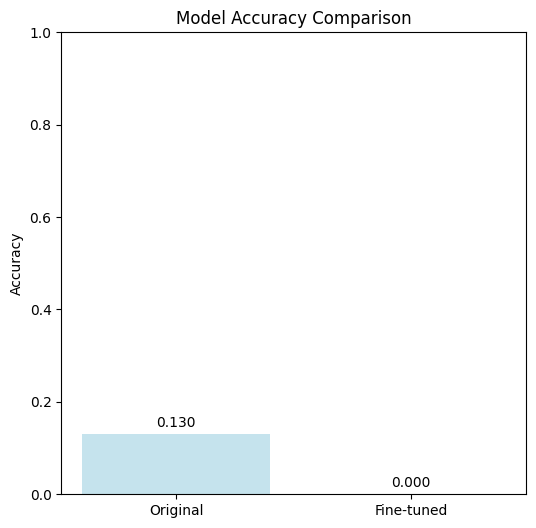

In [21]:
# Create visualizations
plt.figure(figsize=(6, 6))

# 1. Accuracy comparison
models = ['Original', 'Fine-tuned']
accuracies = [results['accuracy'], improved_results['accuracy']]
colors = ['lightblue', 'lightgreen']
bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)

# Add value labels
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

This section shows how model predictions changed after fine-tuning.

Change Types:
- **Still Wrong**: Incorrect before and after
- **Still Correct**: Correct before and after
- **Newly Correct**: Fixed by fine-tuning
- **Newly Wrong**: Became incorrect after fine-tuning

Text(0.5, 1.0, 'Prediction Changes')

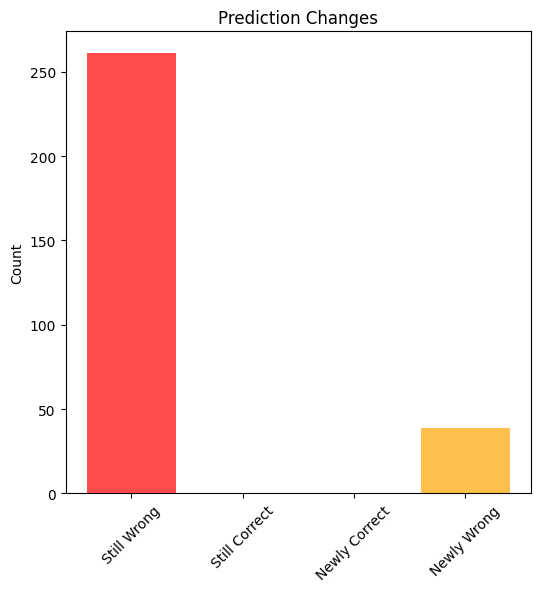

In [22]:
# 2. Improvement breakdown
plt.figure(figsize=(6, 6))
improvement_data = {
    'Still Wrong': sum(1 for o, i in zip(results['correct'], improved_results['correct']) if not o and not i),
    'Still Correct': sum(1 for o, i in zip(results['correct'], improved_results['correct']) if o and i),
    'Newly Correct': sum(1 for o, i in zip(results['correct'], improved_results['correct']) if not o and i),
    'Newly Wrong': sum(1 for o, i in zip(results['correct'], improved_results['correct']) if o and not i)
}

colors = ['red', 'green', 'lightgreen', 'orange']
plt.bar(range(len(improvement_data)), list(improvement_data.values()), 
        color=colors, alpha=0.7)
plt.xticks(range(len(improvement_data)), list(improvement_data.keys()), rotation=45)
plt.ylabel('Count')
plt.title('Prediction Changes')

## Final Results Summary <a id="finalresultssummary"></a>

This section gives a quick overview of your model improvements:

In [23]:
# Print final summary
print("\n" + "="*60)
print("📊 FINAL RESULTS SUMMARY")
print("="*60)
print(f"Original Model Accuracy:    {results['accuracy']:.4f}")
print(f"Fine-tuned Model Accuracy:  {improved_results['accuracy']:.4f}")

improvement = improved_results['accuracy'] - results['accuracy']
print(f"Absolute Improvement:       {improvement:+.4f}")

if results['accuracy'] > 0:
    relative_improvement = (improvement / results['accuracy']) * 100
    print(f"Relative Improvement:       {relative_improvement:+.2f}%")

print(f"\nCorrect Predictions:")
print(f"  Original:    {sum(results['correct'])}/{len(results['correct'])}")
print(f"  Fine-tuned:  {sum(improved_results['correct'])}/{len(improved_results['correct'])}")
print(f"  Net Gain:    {sum(improved_results['correct']) - sum(results['correct'])}")



📊 FINAL RESULTS SUMMARY
Original Model Accuracy:    0.1300
Fine-tuned Model Accuracy:  0.0000
Absolute Improvement:       -0.1300
Relative Improvement:       -100.00%

Correct Predictions:
  Original:    39/300
  Fine-tuned:  0/300
  Net Gain:    -39
